<a href="https://colab.research.google.com/github/jcm0314/Kaggle/blob/main/Titanic_Top_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

titanic_path = kagglehub.competition_download('titanic')
brendan45774_gender_submisson_path = kagglehub.dataset_download('brendan45774/gender-submisson')
brendan45774_test_file_path = kagglehub.dataset_download('brendan45774/test-file')

print('Data source import complete.')


![image.png](attachment:image.png)

If you want to learn more, interact with others, or share around ML. You can feel free to join this community: https://discord.gg/PPwxp2Uv6B

In [ ]:
## 모델링을 위한 초기 설정

# 필요한 라이브러리 임포트

import numpy as np
import pandas as pd
import io
import requests
import re
import warnings
import os
import matplotlib.pyplot as plt  # plt 별칭을 사용하여 matplotlib.pyplot을 임포트
print(os.listdir("../input")) # 디렉토리 탐색
import sklearn
import xgboost as xgb

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates
import plotly.offline as py
py.init_notebook_mode(connected=True) # Plotly 초기화 -> 인터렉티브한 시각화 가능
plt.style.use('seaborn-notebook') # 맷플롯립 스타일 설정
import plotly.graph_objs as go
import plotly.tools as tls

import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

# Kaggle 데이터셋 파일 탐색
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

['gender-submisson', 'titanic', 'test-file']


/kaggle/input/gender-submisson/All 1.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/test-file/tested.csv


In [ ]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv") # Titanic 훈련 데이터 불러옴
df_train = pd.read_csv("/kaggle/input/titanic/train.csv") # 위와 동일한 데이터를 df_train에 불러옴
train_data.head() # 상위 5개 행 출력으로 데이터의 구조와 내용 확인

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv") # 테스트 데이터 불러옴
test_data.head() # 상위 5개 행 출력으로 데이터의 구조와 내용 확인

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# Print train and test columns
test = pd.read_csv("../input/titanic/test.csv") # Titanic 테스트 데이터를 불러옴
train = pd.read_csv("../input/titanic/train.csv") # Titanic 훈련 데이터를 불러옴
print('Train columns:', train.columns.tolist()) # 훈련 데이터의 열 이름을 리스트 형태로 출력
print('Test columns:', test.columns.tolist()) # 테스트 데이터의 열 이름을 리스트 형태로 출력

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Test columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [ ]:
#This is test file from titanic and gender_submission combined
tested = pd.read_csv("../input/test-file/tested.csv") #Titanic 데이터셋의 테스트 파일과 gender_submission 파일을 결합한 데이터 파일을 불러옴
tested.head() # 상위 5개 행 출력으로 데이터의 구조와 내용 확인

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
PassengerId = test['PassengerId'] # 테스트 데이터에서 승객 ID를 추출하여 PassengerId 변수에 저장
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3]) # 훈련 데이터의 Ticket 열에서 처음 3글자를 추출하여 Ticket_type이라는 새로운 열을 생성
train['Ticket_type'] = train['Ticket_type'].astype('category') # Ticket_type 열을 범주형 데이터로 변환 (메모리 사용 최적화)
train['Ticket_type'] = train['Ticket_type'].cat.codes # 범주형 데이터를 수치형 코드로 변환하여 Ticket_type 열을 업데이트

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

In [ ]:
y_train = train['Survived'].ravel() # 훈련 데이터에서 생존 여부(Survived) 열을 추출하여 y_train 변수에 저장, ravel를 이용해 1차원으로 변환
train = train.drop(['Survived'], axis=1) # 훈련 데이터에서 Survived 열을 제거하여 모델 학습에 사용할 피처셋만 남깁니다.
x_train = train.values # 훈련 데이터의 나머지 열을 NumPy 배열 형태로 변환하여 x_train 변수에 저장
x_test = test.values # 테스트 데이터의 모든 열을 NumPy 배열 형태로 변환하여 x_test 변수에 저장

In [ ]:
# 이름에서 호칭을 추출하는 함수 정의
def get_title(name):

    # 정규 표현식을 사용하여 이름에서 호칭을 추출
    title_search = re.search(r',\s*([^\.]*)\. ', name)
    if title_search:
        return title_search.group(1)  # 호칭을 반환
    return ""  # 호칭을 찾지 못한 경우 빈 문자열 반환

full_data = [train, test]

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title) # 각 데이터셋에서 승객의 이름(Name)에서 호칭(Title)을 추출하여 새로운 열을 생성
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data: # 많이 안 쓰이는 호칭을 Rare로 통합
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') # Mile, Ms를 Miss로 통합
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') # Mme를 Mrs로 통합

# Gender(성별)

In [ ]:
gender_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv") # gender_submission 파일 불러옴
gender_data.head() # 상위 5개 행 출력으로 데이터의 구조와 내용 확인

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
gender = pd.read_csv("../input/titanic/gender_submission.csv") # Titanic 데이터셋의 성별 제출 파일을 불러옴
print('Gender columns:', gender.columns.tolist()) # 불러온 데이터의 열 이름을 리스트 형태로 출력하여 데이터의 구조를 확인

Gender columns: ['PassengerId', 'Survived']


In [ ]:
women = train_data.loc[train_data.Sex == 'female']["Survived"] # 훈련 데이터에서 성별이 'female'인 승객의 생존 여부(Survived) 열을 선택
rate_women = sum(women)/len(women) # 여성 승객의 생존 비율을 계산

print("% of women who survived:", rate_women) # 여성 승객의 생존 비율을 출력

% of women who survived: 0.7420382165605095


**Women and children** were the first to board the titanic which means they are more likely to survive than men

In [ ]:
men = train_data.loc[train_data.Sex == 'male']["Survived"] # 훈련 데이터에서 성별이 'male'인 승객의 생존 여부(Survived) 열을 선택
rate_men = sum(men)/len(men) # 남성 승객의 생존 비율을 계산

print("% of men who survived:", rate_men) # 남성 승객의 생존 비율을 출력

% of men who survived: 0.18890814558058924


# Age(나이)

The younger you are the more likely to survive

In [ ]:
data = [train_data, test_data] # 훈련 데이터와 테스트 데이터를 리스트에 저장
for dataset in data:
    mean = train_data["Age"].mean() # 평균
    std = test_data["Age"].std() # 표준편차
    is_null = dataset["Age"].isnull().sum() # 결측값 계산 -> 누락된 값
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null) # 평균과 표준편차를 기반으로 누락된 값은 랜덤 생성
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()  # 'Age' 복사본을 만들어 결측값을 랜덤 나이로 대체
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice # 랜덤 나이로 채워진 'Age' 열을 원래 데이터셋에 업데이트
    dataset["Age"] = train_data["Age"].astype(int)  # 'Age' 열의 데이터를 float(부동소수점형) -> 정수형으로 변환

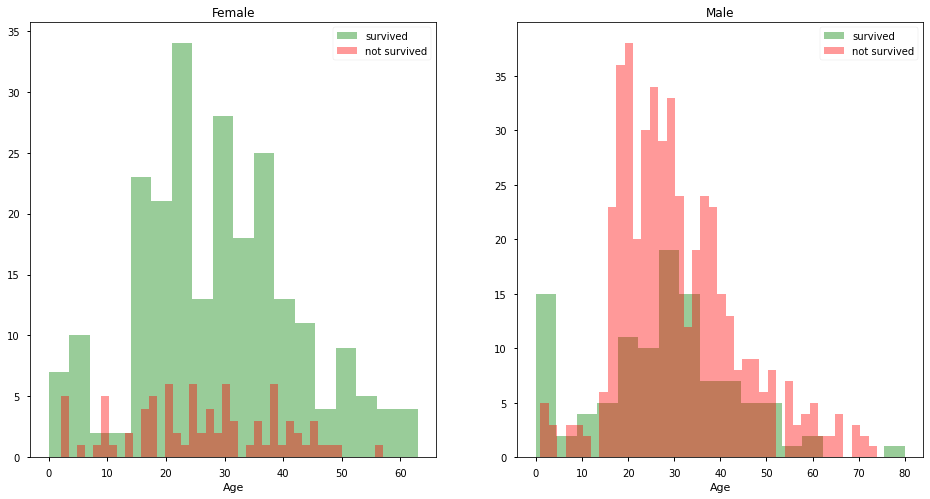

In [ ]:
survived = 'survived' # 생존 여부에 대한 레이블을 정의
not_survived = 'not survived' # 생존 여부에 대한 레이블을 정의
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8)) # 1행 2열의 서브플롯을 생성하고, 전체 크기를 설정
women = train_data[train_data['Sex']=='female'] # 훈련 데이터에서 여성 승객을 선택
men = train_data[train_data['Sex']=='male'] # 훈련 데이터에서 남성 승객을 선택

# 여성 승객 중 생존한 승객의 나이 분포를 시각화
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")

# 여성 승객 중 생존하지 않은 승객의 나이 분포를 시각화
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend() # 범례를 추가
ax.set_title('Female') # 첫 번째 서브플롯의 제목을 Female로 설정

# 남성 승객 중 생존한 승객의 나이 분포를 시각화
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")

# 남성 승객 중 생존하지 않은 승객의 나이 분포를 시각화
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend() # 범례를 추가
_ = ax.set_title('Male'); # 두 번째 서브플롯의 제목을 Male로 설정

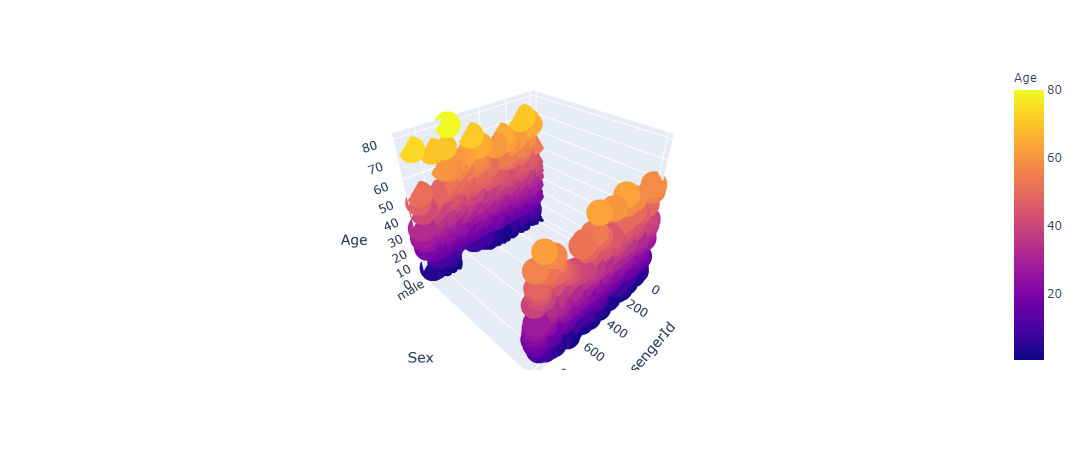

In [ ]:
df = pd.read_csv('../input/titanic/train.csv') # 훈련 데이터 불러오기
fig = px.scatter_3d(df, x='PassengerId', y='Sex', z='Age',
                    color='Age') # 3D 산점도를 생성합니다. x축은 'PassengerId', y축은 'Sex', z축은 'Age'
fig.show() # 생성된 3D 산점도를 표시

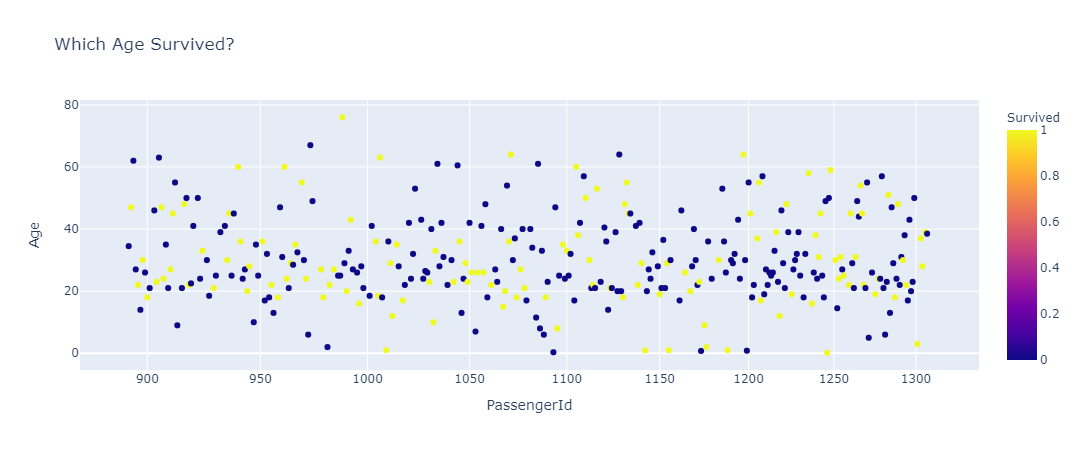

In [ ]:
df = pd.read_csv('../input/test-file/tested.csv') # 테스트 파일 불러오기

for template in ["plotly"]: #'plotly' 템플릿을 사용하여 산점도를 생성
    fig = px.scatter(df,
                     x="PassengerId", y="Age", color="Survived", # x축에는 승객 ID를 y축에는 나이를 설정, 색상은 생존에 따라 다르게 설정
                     log_x=True, size_max=20, # x축을 로그 스케일로 설정, 최대크기 20 설정
                     template=template, title="Which Age Survived?") # 제목을 Which age survived로 설정
    fig.show() # 생성된 산점도를 화면에 표시

# Class(계층)

You have a higher chance of surviving if you have a first class ticket than having a second or third

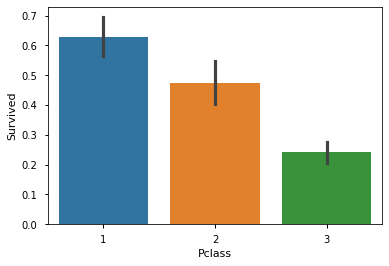

In [ ]:
# Seaborn 라이브러리를 사용해 그래프 생성
# x축에는 승객의 클래스(Pclass), y축에는 생존 여부(Survived)를 설정
sns.barplot(x='Pclass', y='Survived', data=train_data);

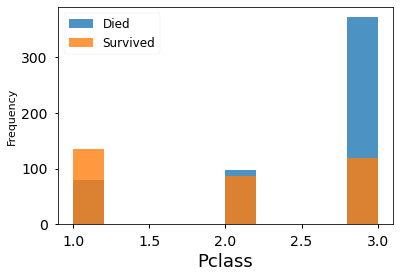

In [ ]:
plt.rc('xtick', labelsize=14) # x축과 y축의 눈금 레이블 크기를 설정
plt.rc('ytick', labelsize=14)

plt.figure() # 새로운 그림을 생성

# 'Survived'에 따라 'Pclass'를 그룹화하여 히스토그램을 생성
fig = df_train.groupby('Survived')['Pclass'].plot.hist(histtype= 'bar', alpha = 0.8)

plt.legend(('Died','Survived'), fontsize = 12) # 범례를 추가하여 생존 여부를 설명
plt.xlabel('Pclass', fontsize = 18) # x축 레이블을 설정
plt.show()

# Embark(승선한 곳)

Women will survive more if they embarked from port ‘Southampton’ or ‘ Queenstown’. While men will survive more from the port 'Cherbourg'. Passengers from port **‘**Southampton**’** have a low survival rate of **34%**,
while those from the port **‘**Cherbourg**’** have a survival rate of **55%**.
Over **72%** of the passengers embarked from the port 'Southampton’, 18% from the port ‘Cherbourg’ and the rest from the port ‘Queenstown’.

In [ ]:
embarked_mode = train_data['Embarked'].mode() # 'Embarked' 열의 최빈값(mode)을 계산
data = [train_data, test_data]
# 각 데이터셋에 대해 결측값을 최빈값으로 채우기
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)  # 'Embarked' 열의 결측값을 최빈값으로 대체

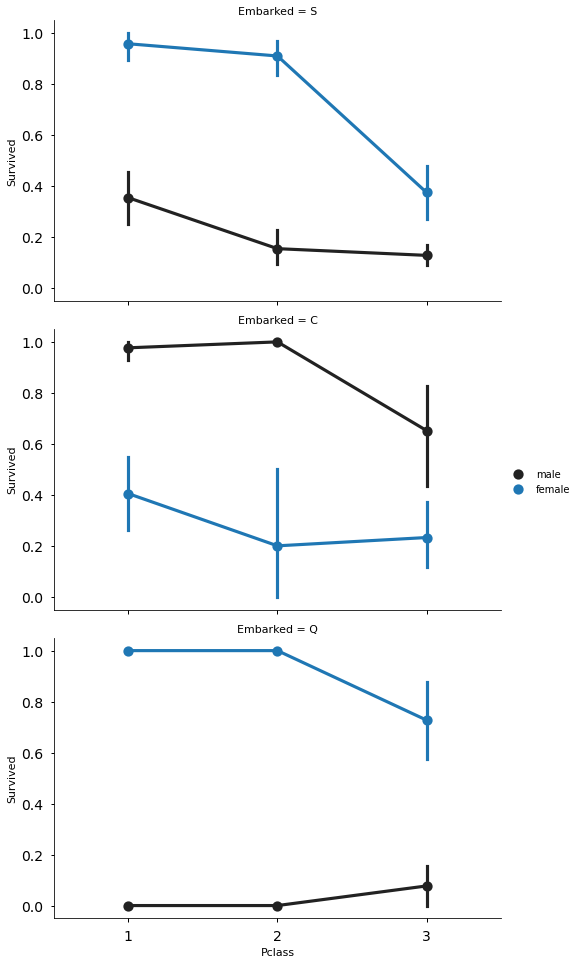

In [ ]:
# Seaborn의 FacetGrid를 사용하여 'Embarked'에 따라 데이터를 나누어 시각화
FacetGrid = sns.FacetGrid(train_data, row='Embarked', height=4.5, aspect=1.6)

# x축은 'Pclass', y축은 'Survived', 색상은 'Sex'에 따라 다르게 설정합니다.
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend(); # 범례를 추가

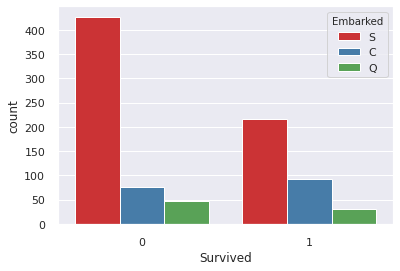

In [ ]:
sns.set(style="darkgrid") # 그래프의 배경을 어두운 그리드 스타일로 변경

# x축에는 생존 여부(Survived)를 설정하고, hue 매개변수로 'Embarked'에 따라 색상다르게 설정
sns.countplot( x='Survived', data=train_data, hue="Embarked", palette="Set1");

# Relatives(Sipsp[배우자], Parch[부모,자식])

You are more likly to survive if you are travels with 1 to 3 people and if you have 0 or more than three you have a less chance.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



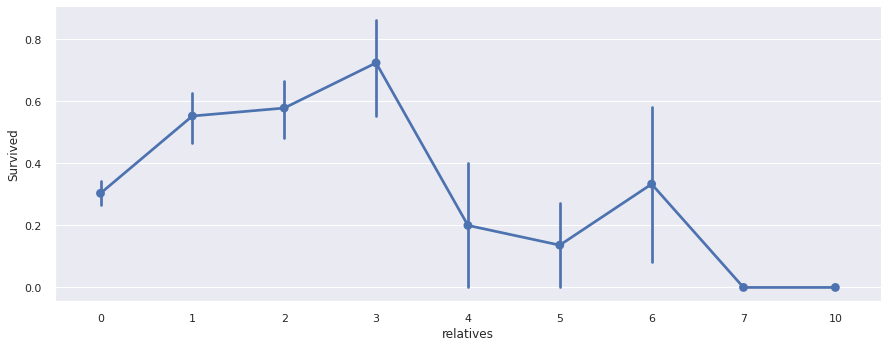

In [ ]:
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']   # 'SibSp'와 'Parch' 열을 더하여 'relatives' 열을 생성

    # 'relatives'가 0보다 큰 경우 'travelled_alone' 열에 'No'를 설정
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'

    # 'relatives'가 0인 경우 'travelled_alone' 열에 'Yes'를 설정합니다.
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'

# 'relatives'와 'Survived' 간의 관계를 시각화하기 위해 factorplot을 생성
axes = sns.factorplot('relatives','Survived',
                      data=train_data, aspect = 2.5, );

Shows the number of females and males who has number of siblings or spouse that is Parch.

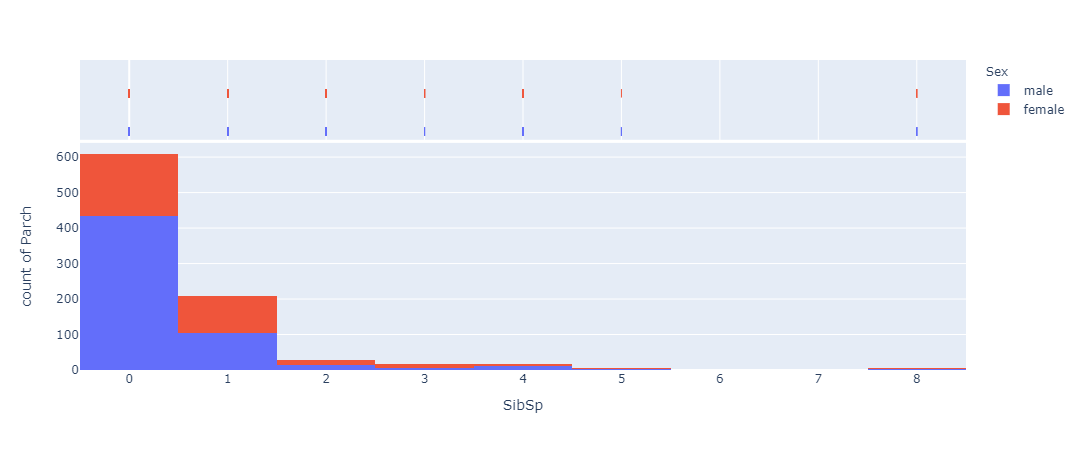

In [ ]:
df = pd.read_csv("../input/titanic/train.csv")
fig = px.histogram(df,
                   x="SibSp", # x축에는 형제/자매 수(SibSp)를 설정
                   y="Parch", # y축에는 부모/자녀 수(Parch)를 설정
                   color="Sex", # 색상은 성별(Sex)에 따라 다르게 설정
                   marginal="rug", # 가장자리에 러그 플롯을 추가하여 데이터 분포를 표시
                   hover_data=df.columns) # 마우스를 올렸을 때 모든 열의 데이터를 표시
fig.show()

In [ ]:
'''# 훈련 데이터에서 수치형 특성(정수형 및 실수형)을 선택하여 리스트로 저장
train_numerical_features = list(train_data.select_dtypes(include=['int64', 'float64', 'int32']).columns)

# StandardScaler 객체를 생성합니다. 이 객체는 데이터를 표준화하는 데 사용
ss_scaler = StandardScaler()

# 훈련 데이터를 복사하여 새로운 데이터프레임을 생성
train_data_ss = pd.DataFrame(data = train_data)

# 각 특성의 평균을 0, 표준편차를 1로 변환
train_data_ss[train_numerical_features] = ss_scaler.fit_transform(train_data_ss[train_numerical_features])'''

"# 훈련 데이터에서 수치형 특성(정수형 및 실수형)을 선택하여 리스트로 저장\ntrain_numerical_features = list(train_data.select_dtypes(include=['int64', 'float64', 'int32']).columns)\n\n# StandardScaler 객체를 생성합니다. 이 객체는 데이터를 표준화하는 데 사용\nss_scaler = StandardScaler()\n\n# 훈련 데이터를 복사하여 새로운 데이터프레임을 생성\ntrain_data_ss = pd.DataFrame(data = train_data)\n\n# 각 특성의 평균을 0, 표준편차를 1로 변환\ntrain_data_ss[train_numerical_features] = ss_scaler.fit_transform(train_data_ss[train_numerical_features])"

In [ ]:
# train_data_ss.head()

In [ ]:
# 하이퍼파라미터 튜닝을 위한 파라미터 그리드를 정의
param_test1 = {
    'n_estimators': [100,200,500,750,1000], # 부트스트랩 샘플의 수를 설정(트리 갯수)
    'max_depth': [3,5,7,9], # 트리의 최대 깊이를 설정
    'min_child_weight': [1,3,5],  # 자식 노드를 만들기 위한 최소 가중치를 설정
    'gamma':[i/10.0 for i in range(0,5)], # 분할을 위해 필요한 최소 손실 감소를 설정
    'subsample':[i/10.0 for i in range(6,10)], # 각 트리를 만들 때 사용할 샘플의 비율을 설정
    'colsample_bytree':[i/10.0 for i in range(6,10)], # 각 트리를 만들 때 사용할 열(특성)의 비율을 설정
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 1], # L1 정규화의 강도를 설정
    'learning_rate': [0.01, 0.02, 0.05, 0.1] # 학습률을 설정
}

In [ ]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,travelled_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,No
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,No
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Yes
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,No
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,Yes
5,6,0,3,"Moran, Mr. James",male,20,0,0,330877,8.4583,NaN,Q,0,Yes
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,0,Yes
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S,4,No
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S,2,No
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C,1,No


This shows an estimate of the output, so not exact. 1 Shows if the person had survived, while 0 shows that person died.

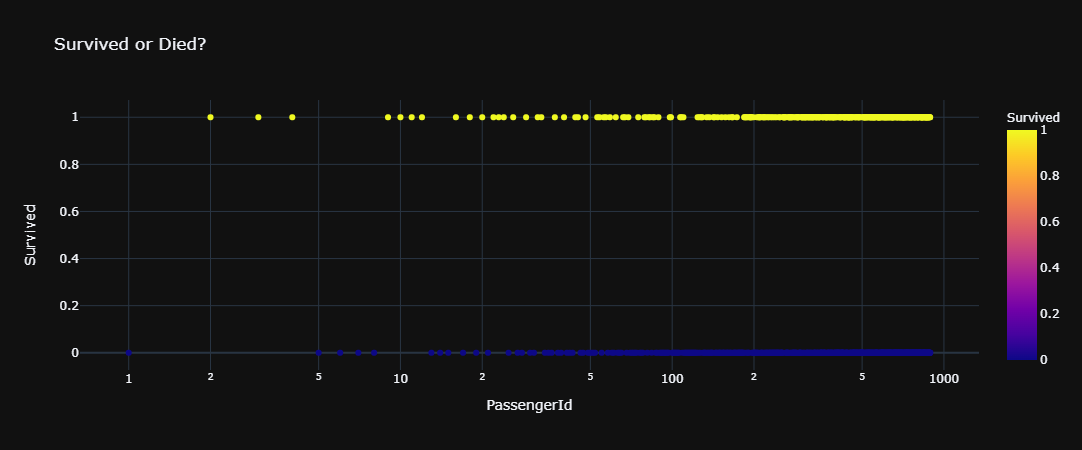

In [ ]:
for template in ["plotly_dark"]:
    fig = px.scatter(df,
                     x="PassengerId", # x축에는 승객 ID(PassengerId)를 설정
                     y="Survived", # y축에는 생존 여부(Survived)를 설정
                     color="Survived", # 생존 여부에 따라 색상을 다르게 설정
                     log_x=True, # x축을 로그 스케일로 설정하여 데이터의 분포를 개선
                     size_max=20, # 점의 최대 크기를 20으로 설정
                     template=template, # 지정한 템플릿을 사용하여 그래프 스타일을 설정
                     title="Survived or Died?") # 그래프의 제목을 설정
    fig.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#data["Age"] = data["Age"].astype(int)
#if ["Age"]

y = train_data["Survived"] # y 생존 여부

features = ["Pclass", "Sex", "SibSp", "Parch"] # 특성 정의
X = pd.get_dummies(train_data[features]) # 테스트 데이터에서 더미 변수 생성
X_test = pd.get_dummies(test_data[features]) # 테스트 데이터에서 더미 변수 생성

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2) # 트리 갯수, 깊이, 시드 설정
model.fit(X, y) # 학습
predictions = model.predict(X_test) # 예측

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions}) # 예측 결과 저장
output.to_csv('submission.csv', index=False) # 파일로 저장

# In conclusion(결론)
 **There are many things for a greater chance to survive. Being a female or a child will increase you chances. If you have a higher class ticket you have the more chance of surviving than a third class ticket. As for a man, you are more likely to survive if embark in Cherbourg compare to Southampton or Queenstown. If you also travel with 1 or 3 people than 0 or more than 3 your survival chances are greater. The younger you are will also make your survival chance. So it comes down to many things to surivive on the titanic.**

# If you like this notebook, please give an Upvote! Don't forget to check out my other notebooks too!

* [ConnectX Baseline](https://www.kaggle.com/brendan45774/connectx-baseline)
* [Countries Life Expectancy Animation](https://www.kaggle.com/brendan45774/countries-life-expectancy-animation)
* [Data Visuals - Matplotlib](http://www.kaggle.com/brendan45774/data-visuals-matplotlib)
* [Digit Recognizer Solution](http://www.kaggle.com/brendan45774/digit-recognizer-solution)
* [Dictionary and Pandas Cheat sheet](https://www.kaggle.com/brendan45774/dictionary-and-pandas-cheat-sheet)
* [EDA Tutorial Hollywood Movies](https://www.kaggle.com/brendan45774/eda-tutorial-hollywood-movies)
* [Getting Started with Manifold Learning - Isomap](https://www.kaggle.com/brendan45774/getting-started-with-manifold-learning-isomap)
* [Getting started with Matplotlib](http://www.kaggle.com/brendan45774/getting-started-with-matplotlib)
* [Guide to Matplotlib Image](https://www.kaggle.com/brendan45774/guide-to-matplotlib-image)
* [HOG features - Histogram of Oriented Gradients](https://www.kaggle.com/brendan45774/hog-features-histogram-of-oriented-gradients)
* [How to get the lowest score](https://www.kaggle.com/brendan45774/how-to-get-the-lowest-score)
* [House predict solution](http://www.kaggle.com/brendan45774/house-predict-solution)
* [K-Means Clustering (Image Compression)](https://www.kaggle.com/brendan45774/k-means-clustering-image-compression)
* [Kuzushiji-MNIST Panda](http://www.kaggle.com/brendan45774/kuzushiji-mnist-panda)
* [Plotly Coronavirus (Covid-19)](https://www.kaggle.com/brendan45774/plotly-coronavirus-covid-19)
* [Titanic Top Solution](http://www.kaggle.com/brendan45774/titanic-top-solution)
* [Titanic Data Solution](http://www.kaggle.com/brendan45774/titanic-data-solution)
* [Topic Modeling (LDA)](https://www.kaggle.com/brendan45774/topic-modeling-lda)
* [Word Cloud - Analyzing Names](https://www.kaggle.com/brendan45774/word-cloud-analyzing-names)